In [1]:
import sys, os, json, pickle, gzip, copy, torch, numbers, tqdm
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from src.utils import ActiveElements, MetalElements, Element, AllElements
from src.utils import composit_parser
from src.feature import composition_to_feature

from pymatgen.core import Composition, Element

from scipy.stats import gaussian_kde
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR

In [2]:
from src.data import ReactionGraphDataset, ReactionDataset
from src.networks import GraphCVAE, CVAE, GraphConvolutionBlock, GraphAttentionBlock
from src.trainer import VAETrainer, BaseTrainer

GDSM = ReactionGraphDataset(feat_type='cgcnn')
GDSM.from_file('../data/screened_single_source_conditional_reaction.pkl.gz', 
               heat_temp_key=('heat_temp','median'),
               heat_time_key=('heat_time','median'))

In [3]:
feats, info = GDSM.cfn(GDSM)
years = np.array([d.year for d in GDSM])
feat = feats['target_feat']
label = feats['condition_feat']

test_mask = years > 2017
train_mask = years <= 2017

x_train = feat[train_mask]
y_train = label[train_mask]
x_test = feat[test_mask]
y_test = label[test_mask]



In [44]:
dl = DataLoader([[x, y] for x, y in zip(x_train, y_train)], batch_size=32)
_x, _y = next(iter(dl))
_x.shape, _y.shape

(torch.Size([32, 91]), torch.Size([32, 2]))

In [26]:
import gpytorch

class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, num_tasks):
        batch_shape = inducing_points.size()[1:]
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.shape[0], batch_shape)
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=num_tasks,
            num_latents=batch_shape[0],
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(batch_shape=batch_shape), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = GPModel(x_train[:200], y_train[:200], likelihood)

model.train()
likelihood.train()

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)

#for i in range(50):
#    opt.zero_grad()
#    out = model(x_train)
#    loss = -mll(out, y_train)
#    loss.backward()
#    print(''.format(
#        i, loss, model.covar_module.base_kernel.lengthscale.item()
#    ))


In [28]:
out = model(x_train[:200])
-mll(out, y_train[:200])

tensor(1.1555, grad_fn=<NegBackward0>)

In [38]:
x_train.size()[1:]

91

In [6]:
rxn_id = []
temp_1 = []
temp_2 = []
for i, data in enumerate(GDSM):
    rxn_id.append([i] * data.n)
    temp_1.append(data.condition_feat.repeat(data.n, 1))
    temp_2.append(data.condition_feat)

rxn_id = np.hstack(rxn_id)
temp_1 = torch.vstack(temp_1)
temp_2 = torch.vstack(temp_2)


In [7]:
temp_1.shape, temp_2.shape, rxn_id.shape

(torch.Size([141043, 1]), torch.Size([35729, 1]), (141043,))

In [84]:
feat, info = GDSM.cfn(GDSM[100:200])
feat['target_feat'].shape, feat['rxn_id'].shape

(torch.Size([100, 91]), (379,))

In [107]:
inp = feat['target_feat']
tgt = feat['condition_feat']
dist = torch.cdist(inp, inp, p=2)
length, var, noise = torch.tensor([1.0, 1.0, 0.01], requires_grad=True)
N = inp.shape[0]
K1 = var * torch.exp(-0.5 * dist / length ** 2) + torch.eye(N) * noise
L1 = torch.linalg.cholesky(K1)


In [113]:
def kernel_mat_self(X, length, var, noise):
    sq = (X**2).sum(dim=1, keepdim=True)
    sqdist = sq + sq.T - 2 * X.mm(X.T)
    return var * torch.exp(
        -0.5 * sqdist / length
    ) + noise * torch.eye(len(X))

K2 = kernel_mat_self(inp, length, var, noise)
L2 = torch.linalg.cholesky(K2)

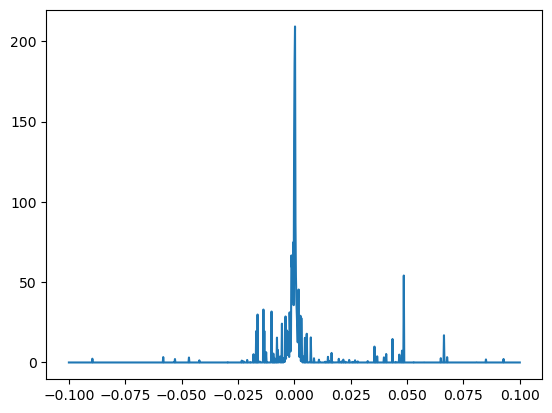

In [116]:
g = gaussian_kde((L1 - L2).detach().reshape(-1).numpy(), 0.001)
x = np.linspace(-0.1, 0.1, 1000)
plt.plot(x, g(x))

In [124]:
log_det_K = 2 * torch.sum(torch.log(torch.linalg.diagonal(L1)))
alpha = torch.cholesky_solve(tgt, L1)

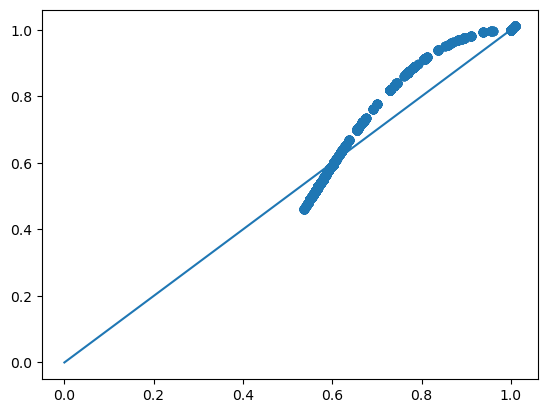

In [131]:
plt.scatter(K1.detach().reshape(-1).numpy(), K2.detach().reshape(-1).numpy())
plt.plot([0, 1],[0,1])

In [77]:
nll_loss = (
    0.5 * tgt.T @ alpha +
    0.5 * log_det_K + 
    0.5 * N * torch.log(torch.tensor(2 * torch.pi))
)

In [126]:
from src.networks import FCNNBlock


model = FCNNBlock(input_dim=91, output_dim=4, batch_norm=True, dropout=0)

def process(model, X, Y):
    pred = model(X)
    torch.chunk(pred, 2, dim=-1)

(tensor([[167.1290,  41.9523],
         [ 41.9523, 819.8628]], grad_fn=<MmBackward0>),
 tensor([[167.1290,  41.9523],
         [ 41.9523, 819.8628]], grad_fn=<MmBackward0>))

In [46]:
x_train.shape, y_train.shape

(torch.Size([26497, 91]), torch.Size([26497, 2]))

In [ ]:
class RBFKernel(torch.nn.Module):
    def __init__(self, input_dim):
        super(RBFKernel, self).__init__()
        self.input_dim = input_dim
        self.variance = torch.nn.Parameter(torch.tensor([1.0]), requires_grad=True)
        self.lengthscale = torch.nn.Parameter(torch.randn(input_dim).abs(), requires_grad=True)

    def forward(self, x1, x2=None):
        # Compute the squared Euclidean distance between x1 and x2
        x1 = x1 / self.lengthscale
        x1s = torch.pow(x1, 2).sum(1)

        if x2 is None: 
            dist = -2 * x1.mm(x1.T) + x1s.view(-1,1) + x1s.view(1,-1)
        else:
            x2 = x2 / self.lengthscale
            x2s = torch.pow(x2, 2).sum(1)
            dist = -2 * x1.mm(x2.T) + x1s.view(-1,1) + x2s.view(1,-1)

        # Compute the kernel matrix
        kernel_matrix = self.variance * torch.exp(-0.5 * dist)

        return kernel_matrix


In [59]:
torch.abs(torch.randn(10))

tensor([1.2797, 0.5692, 0.6242, 1.7780, 0.7217, 0.8491, 0.5731, 0.8418, 0.6193,
        0.3363])

In [76]:
x = torch.rand(256, 91)

In [74]:
def f1(x):
    return torch.pow(torch.cdist(x, x), 2)

def f2(x):
    xs = torch.pow(x, 2).sum(1)
    return -2 * x.mm(x.T) + xs.view(1,-1) + xs.view(-1,1)

%timeit f1(x)
%timeit f2(x)

39.3 µs ± 92 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
23.1 µs ± 31.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [75]:
f1(x) - f2(x)

tensor([[ 0.0000e+00, -1.9073e-06, -1.9073e-06,  ...,  1.9073e-06,
         -5.7220e-06,  0.0000e+00],
        [-1.9073e-06,  0.0000e+00, -4.7684e-06,  ..., -1.9073e-06,
          0.0000e+00, -2.8610e-06],
        [-1.9073e-06, -4.7684e-06,  7.6294e-06,  ..., -1.9073e-06,
         -1.9073e-06,  0.0000e+00],
        ...,
        [-1.9073e-06, -1.9073e-06,  1.9073e-06,  ...,  0.0000e+00,
         -1.9073e-06, -1.9073e-06],
        [-5.7220e-06,  0.0000e+00, -1.9073e-06,  ..., -1.9073e-06,
          0.0000e+00,  9.5367e-07],
        [ 0.0000e+00, -2.8610e-06,  0.0000e+00,  ..., -1.9073e-06,
          9.5367e-07,  3.8147e-06]], device='cuda:0')

# check distribution of conditions - temp & time

In [ ]:
from sklearn.manifold import TSNE

tvec = TSNE().fit_transform(feat.numpy())
tx, ty = tvec.T
y1, y2 = label.numpy().T

In [166]:
g1x, g1y, g1z = [v.reshape(-1) for v in np.meshgrid(np.linspace(-150,150,15), np.linspace(-150,150,15), np.linspace(-1,2,15))]
g2x, g2y, g2z = [v.reshape(-1) for v in np.meshgrid(np.linspace(-150,150,15), np.linspace(-150,150,15), np.linspace(-3,2,15))]

In [168]:
import plotly.express as px
g1 = gaussian_kde(np.vstack([tx, ty, y1]))
c1 = g1(np.vstack([g1x, g1y, g1z]))
px.scatter_3d(x=g1x, y=g1y, z=g1z, color=c1, opacity=0.8, size=c1, size_max=40, height=800)

In [170]:
g2 = gaussian_kde(np.vstack([tx, ty, y2]))
c2 = g2(np.vstack([g2x, g2y, g2z]))
px.scatter_3d(x=g2x, y=g2y, z=g2z, color=c2, opacity=0.9, size=c2, size_max=30, height=800)